In [ ]:
# Load model directly
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("liuhaotian/llava-lcs558k-scienceqa-vicuna-13b-v1.3")

In [ ]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA
!pip install -q gradio .


In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
#from llava.model import LlavaLlamaForCausalLM
from transformers import AutoModelForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
#model_path = 'liuhaotian/llava-lcs558k-scienceqa-vicuna-13b-v1.3'
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
#model = AutoModelForCausalLM.from_pretrained("liuhaotian/llava-lcs558k-scienceqa-vicuna-13b-v1.3")

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def image_preprocess(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

def middel_interface(image_files, prompt):
    for image_file in image_files:
        image = image_preprocess(image_file)


    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    print(roles)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output


def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    print(roles)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

[2023-11-27 10:34:05,111] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mkdir /content/images
!wget --header 'Authorization: Bearer TOKEN_HERE' https://huggingface.co/camenduru/polaroid/resolve/main/style_name_fix.zip
!unzip style_name_fix.zip -d /content/images

--2023-11-27 10:40:15--  https://huggingface.co/camenduru/polaroid/resolve/main/style_name_fix.zip
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.37, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.
unzip:  cannot find or open style_name_fix.zip, style_name_fix.zip.zip or style_name_fix.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_path = "../drive/MyDrive/ScienceQA_DATA/"
main_path = "drive/MyDrive/ScienceQA_DATA/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls ../

drive  images  LLaVA  sample_data


In [ ]:
import zipfile
for i in ['val', 'train', 'test']:
  file_path = main_path+i+'.zip'
  print(file_path)
  with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

/content/drive/MyDrive/ScienceQA_DATA/val.zip
../drive/MyDrive/ScienceQA_DATA/val.zip
../drive/MyDrive/ScienceQA_DATA/train.zip
../drive/MyDrive/ScienceQA_DATA/test.zip


In [ ]:
!mv train ../drive/MyDrive/ScienceQA_DATA/train

In [ ]:
def image_preprocess(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

def caption_image(image_files, prompt):
    images = []
    for image_file in image_files:
        #print(image_file)
        image = image_preprocess(image_file)
        images.append(image)

    image_tensor = image_processor.preprocess(images, return_tensors='pt')['pixel_values'].half().cuda()
    #print(image_tensor.shape)
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    #print(roles)
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

drive/MyDrive/ScienceQA_DATA/test/5


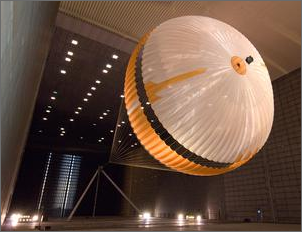

In [ ]:
import json
import os
from IPython.display import Image, display

def read_json(json_file_path):
  # Open the file in read mode
  with open(json_file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)
  return data

pid_split = main_path + 'pid_splits.json'
pid = read_json(pid_split)

# Specify the path to your JSON file
json_file_path = main_path + 'problems.json'
problem_data = read_json(json_file_path)

# problem_id: string
# one question could have multiple images
def display_images(problem_id):
  split_type = problem_data[problem_id]['split']
  images_path = f"{main_path}{split_type}/{problem_id}"
  print(images_path)

  # Get all files in the directory
  files = [images_path+'/'+f for f in os.listdir(images_path)]

  for _file in files:
    # Display the image
    display(Image(filename=_file))

display_images("5")

In [ ]:
latest_path = main_path + 'llava_cot_llama_zeroshot_combined_test_result.json'
latest_data = read_json(latest_path)

cot_path = main_path + 'predictions_ans_test_rationale.json'
cot_rationale = read_json(cot_path)

llava_ans_path = main_path + 'test_sqa_llava_lcs_558k_sqa_12e_vicuna_v1_3_13b.json'
llava_ans = read_json(llava_ans_path)

updated_cap_path = main_path + 'instruct_captions.json'
up_cap = read_json(updated_cap_path)

cot_rat = []
for rat in cot_rationale['preds']:
  cot_rat.append(rat)

print(len(cot_rat))

cot_dict = {}
index = 0
for test_id in pid['test']:
  cot_dict[test_id] = cot_rat[index]
  index += 1

for pid, content in latest_data.items():
  latest_data[pid]['cot_rationale'] = cot_dict[pid]
  latest_data[pid]['llava_finetuned_answer'] = str(llava_ans['results'][pid])
  latest_data[pid]['accurate_image_captions'] = up_cap['captions'][pid]




4241


In [ ]:
# Specify the file path
file_path = main_path+'all_combined_result.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(latest_data, json_file)

In [ ]:
cot_rat = []
for rat in cot_rationale['preds']:
  cot_rat.append(rat)

print(len(cot_rat))

cot_dict = {}
index = 0
for test_id in pid['test']:
  cot_dict[test_id] = cot_pred[index]
  index += 1

llava_path = main_path + 'llava_test_result.json'
ll_res = read_json(llava_path)

for llid in ll_res.keys():
  ll_res[llid]["cot_answer"] = cot_dict[llid]



In [ ]:
import json
import os


def read_json(json_file_path):
  # Open the file in read mode
  with open(json_file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)
  return data

# Specify the path to your JSON file
json_file_path = main_path + 'problems.json'
problem_data = read_json(json_file_path)

# Now 'data' contains the parsed JSON content
print(len(problem_data))

cot_path = main_path + 'predictions_ans_test.json'
cot_result = read_json(cot_path)

print(len(cot_result["preds"]))

pid_split = main_path + 'pid_splits.json'
pid = read_json(pid_split)

print(len(pid['test']))
print(len(pid['minitest']))

combined = pid['test'] + pid['minitest']
print(len(combined))



FileNotFoundError: ignored

In [ ]:
co = 0
for id in pid['test']:
  print(id)
  co +=1
  if co == 10:
    break

4
5
11
15
22
23
26
27
29
42


In [ ]:
# Get a list of all files and directories in the specified directory
contents = os.listdir(main_path+'test')
print(len(contents))

2178


In [ ]:
cot_pred = []
for pred in cot_result['preds']:
  if "A" in pred:
    cot_pred.append("0")
  elif "B" in pred:
    cot_pred.append("1")
  elif "C" in pred:
    cot_pred.append("2")
  elif "D" in pred:
    cot_pred.append("3")
  elif "E" in pred:
    cot_pred.append("4")

print(len(cot_pred))

cot_dict = {}
index = 0
for test_id in pid['test']:
  cot_dict[test_id] = cot_pred[index]
  index += 1

llava_path = main_path + 'llava_test_result.json'
ll_res = read_json(llava_path)

for llid in ll_res.keys():
  ll_res[llid]["cot_answer"] = cot_dict[llid]



4241


In [ ]:
llava_total = 0
cot_total = 0
question_total = len(ll_res)

for id, content in ll_res.items():
  if content['llava_answer'] == str(content['answer']):
    llava_total += 1
  elif str(content['answer']) in content['llava_output']:
    llava_total += 1
  if content['cot_answer'] == str(content['answer']):
    cot_total += 1

llava_acc = llava_total / question_total * 100
cot_acc = cot_total / question_total * 100
print("llava_accuracy: ", llava_acc)
print("cot acuracy: ", cot_acc)

llava_accuracy:  62.96479920674268
cot acuracy:  82.89538919186911


In [ ]:
# Specify the file path
file_path = main_path+'llava_cot_combined_test_result.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(ll_res, json_file)

In [ ]:
c = 0

for test_id in pid['test']:
  if problem_data[test_id]['image']:
    split_type = problem_data[test_id]['split']
    images_path = f"{main_path}{split_type}/{test_id}"
    print(images_path)

    # Get all files in the directory
    files = [images_path+'/'+f for f in os.listdir(images_path)]

    # prompt creation
    question = problem_data[test_id]['question']
    content = f"{question}\n\n"
    choices = problem_data[test_id]['choices']
    for i in range(0,len(choices)):
      this_choice = f"{i}. {choices[i]}\n"
      content += this_choice
    content += f"\nAnswer Choice: "
    #content += f"\nJust answer with 0 ~ {len(choices)}: "
    #print(content)


    image, output = caption_image(files, content)
    print(output)

    problem_data[test_id]['llava_answer'] = output[0]
    problem_data[test_id]['llava_output'] = output

    #c+=1
    #if c == 3:
    #  break
  else:
    print('no images')


Streaming output truncated to the last 5000 lines.
1. Green anole
../drive/MyDrive/ScienceQA_DATA/test/4836
1. Hanson can trade his almonds for Maya's tomatoes.
../drive/MyDrive/ScienceQA_DATA/test/4844
3
../drive/MyDrive/ScienceQA_DATA/test/4851
1
no images
no images
../drive/MyDrive/ScienceQA_DATA/test/4865
1. rock
no images
no images
../drive/MyDrive/ScienceQA_DATA/test/4883
1. February
no images
no images
../drive/MyDrive/ScienceQA_DATA/test/4897
1. New Hampshire
../drive/MyDrive/ScienceQA_DATA/test/4914
0. smooth
../drive/MyDrive/ScienceQA_DATA/test/4918
1. Grenada
../drive/MyDrive/ScienceQA_DATA/test/4919
0. the sand dunes, the prairie sandreed, and the greater prairie chickens
no images
no images
../drive/MyDrive/ScienceQA_DATA/test/4924
0. the number of times the plots were burned each year

Explanation: The independent variable in this experiment is the number of times the plots were burned each year. The image shows a field with a fire, and the fire is spreading across the fi

In [ ]:
tested_results_info = {}

for test_id in pid['test']:
  if problem_data[test_id]['image']:
    tested_results_info[test_id] = problem_data[test_id]

# Specify the file path
file_path = main_path+'llava_test_result.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(tested_results_info, json_file)


In [ ]:
file_names = os.listdir('/content/images')
sorted_file_names = sorted(file_names)
for file_name in sorted_file_names:
    try:
        image, output = caption_image([f'/content/images/{file_name}', f'/content/images/{file_name}'], 'Are there any differences between two pictures?')
        print(output)
        # image
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        continue

/content/images/.ipynb_checkpoints
Error processing .ipynb_checkpoints: [Errno 21] Is a directory: '/content/images/.ipynb_checkpoints'
/content/images/image1.jpg
/content/images/image1.jpg
torch.Size([2, 3, 336, 336])
('Human', 'Assistant')
Yes, there are differences between the two pictures. In the first picture, there is a diagram showing the relationship between various Amazon services, such as AWS Fargate, AWS Lambda, and Amazon API Gateway. The diagram is a flowchart that illustrates the interactions between these services. In the second picture, there is a diagram illustrating the relationship between AWS services and the AWS CloudFront service. This diagram also shows the flow of data between these services. The two diagrams provide different perspectives on the relationships between AWS services and their interactions.
